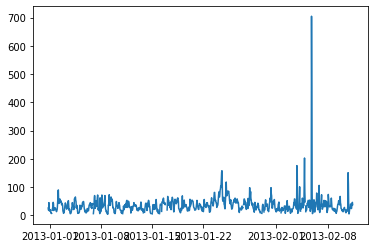

In [7]:
# load JSON
import json
import pandas as pd
 
data = pd.read_pickle('franklin-d-roosevelt/airQualityDataframe-franklin-d-roosevelt-PM10.pkl')
data = data.sort_values(by=['ds'])

df = data[0:1000]

import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
plt.plot(df['ds'],df['y'])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


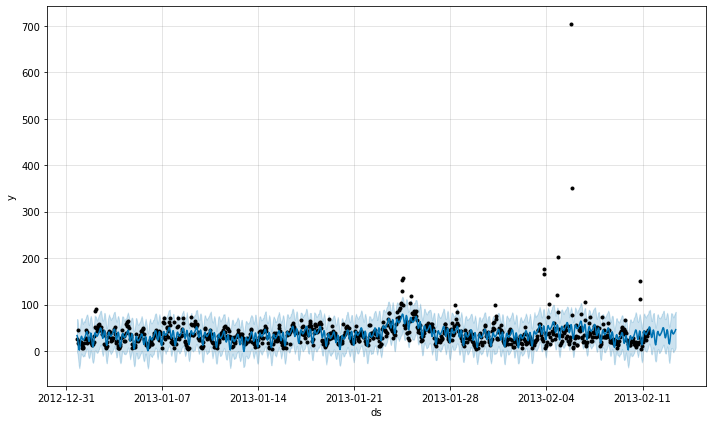

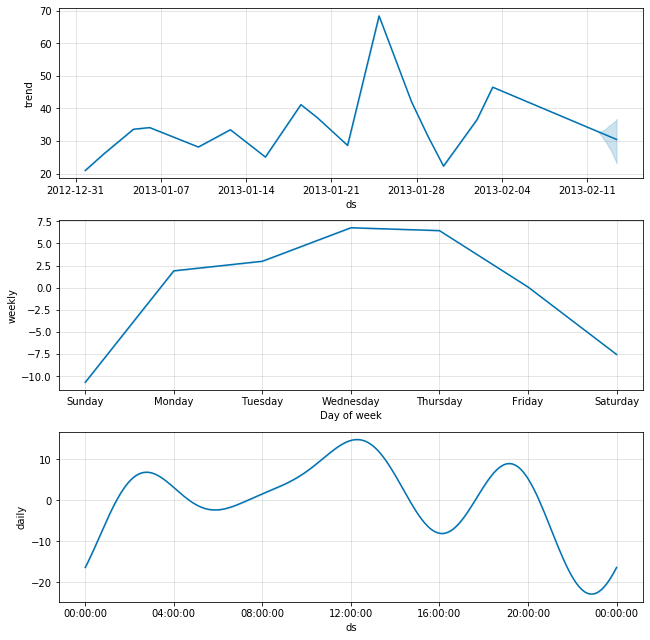

In [8]:
from fbprophet import Prophet
m = Prophet(changepoint_prior_scale=0.5) #  Increasing scale will make the trend more flexible:
m.fit(df)
future = m.make_future_dataframe(periods=48, freq='H')
forecast = m.predict(future)
pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
fig = m.plot(forecast)
components_fig = m.plot_components(forecast)

In [9]:
# PROPHET validation
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='6 days', period='2 days', horizon = '2 days') # horizon: forecast ; initial: training (default: 3x horizon); 
df_cv.head()

INFO:fbprophet:Making 17 forecasts with cutoffs between 2013-01-08 10:00:00 and 2013-02-09 10:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-01-08 11:00:00,51.485777,36.960095,66.795925,48.0,2013-01-08 10:00:00
1,2013-01-08 12:00:00,52.416168,37.480611,66.741342,60.0,2013-01-08 10:00:00
2,2013-01-08 13:00:00,51.879630,36.817849,66.658501,70.0,2013-01-08 10:00:00
3,2013-01-08 14:00:00,49.449496,34.525337,63.405124,35.0,2013-01-08 10:00:00
4,2013-01-08 15:00:00,44.685358,29.986299,59.064702,22.0,2013-01-08 10:00:00


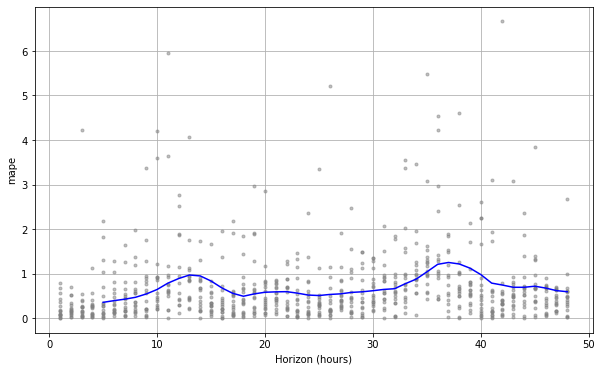

In [10]:
# Performance metrics
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

# mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE)
# computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff).
# By default, 10% of the predictions in each window (can be changed) 
# high rollingwindow --> smoother average curve 

# Visualize cross-validation
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')
